### Simple rule-based allocation of weights for a portfolio of stocks

In [ ]:
import pandas as pd
import numpy as np 
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import permutations, combinations
%matplotlib inline

In [ ]:
def get_price_df(sym_type):
    syms_1 = ['^NSEI', 'NATIONALUM.NS', 'BHEL.NS', 'YESBANK.NS', 'GAIL.NS', 'MRPL.NS', 'ONGC.NS', 'SJVN.NS', 'TATAPOWER.NS']
    syms_2 = ['^BSESN', '^DJI', '^FCHI', '^FTSE', '^GDAXI', '^GSPC', '^IXIC', '^NSEI']
    if sym_type == 'equities':
        price_df = pd.read_csv('datasets/nse_equities_20160101_20201130.csv')
        syms = syms_1
    elif sym_type == 'index':
        price_df = pd.read_csv('datasets/index_ohlcv_10yrs.csv')
        price_df = price_df.rename(columns={'index-name':'sym'})
        syms = syms_2
    else:
        print("Invalid type")

    price_df = price_df.reset_index(drop=True)
    
    return price_df, syms

In [ ]:
def get_ret_df(price_df):
    ret_df = price_df[['Date', 'sym', 'Adj Close']].copy()
    ret_df = ret_df.pivot(index='Date', columns='sym', values='Adj Close')
    ret_df = ret_df/ret_df.shift(1) - 1
    
    return ret_df.dropna(axis=0, how='any')

In [ ]:
def get_filt_df(df_type, price_df):
    if df_type == 1: 
        '''
        Arithmetic returns
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='Adj Close').dropna(axis=0, how='any')
        filt_df = filt_df/filt_df.shift(1) - 1

    elif df_type == 2:
        '''
        Volume change 
        '''
        filt_df = price_df[['Date', 'sym', 'Volume']].copy()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='Volume').dropna(axis=0, how='any')
        filt_df = filt_df/filt_df.shift(1) - 1 
        
    elif df_type == 3:
        '''
        MA5
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='Adj Close').dropna(axis=0, how='any')
        filt_df_ma5 = filt_df.rolling(window=5).mean()
        filt_df = filt_df_ma5/filt_df_ma5.shift(1) - 1
    
    elif df_type == 4:
        '''
        MA20 
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='Adj Close').dropna(axis=0, how='any')
        filt_df_ma20 = filt_df.rolling(window=20).mean()
        filt_df = filt_df_ma20/filt_df_ma20.shift(1) - 1
        
    elif df_type == 5:
        '''
        MA50
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='Adj Close').dropna(axis=0, how='any')
        filt_df_ma50 = filt_df.rolling(window=50).mean()
        filt_df = filt_df_ma50/filt_df_ma50.shift(1) - 1
        
    elif df_type == 6: 
        '''
        MA120
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='Adj Close').dropna(axis=0, how='any')
        filt_df_ma120 = filt_df.rolling(window=120).mean()
        filt_df = filt_df_ma120/filt_df_ma120.shift(1) - 1
        
    elif df_type == 7:
        '''
        AVG(MA20, MA50)
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='Adj Close').dropna(axis=0, how='any')
        filt_df_ma20 = filt_df.rolling(window=20).mean().dropna(axis=0, how='any')
        filt_df_ma50 = filt_df.rolling(window=50).mean().dropna(axis=0, how='any')
        filt_df_merged = (filt_df_ma20 + filt_df_ma50)/2
        filt_df_merged = filt_df_merged.dropna(axis=0, how='any')
        filt_df = filt_df_merged/filt_df_merged.shift(1) - 1
        
    elif df_type == 8:
        '''
        AVG(MA50, MA120)
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='Adj Close').dropna(axis=0, how='any')
        filt_df_ma_50 = filt_df.rolling(window=50).mean().dropna(axis=0, how='any')
        filt_df_ma_120 = filt_df.rolling(window=120).mean().dropna(axis=0, how='any')
        filt_df_merged = (filt_df_ma_50 + filt_df_ma_120)/2
        filt_df_merged = filt_df_merged.dropna(axis=0, how='any')
        filt_df = filt_df_merged/filt_df_merged.shift(1) - 1
        
    elif df_type == 9:
        '''
        AVG(MA20, MA120)
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='Adj Close').dropna(axis=0, how='any')
        filt_df_ma_20 = filt_df.rolling(window=20).mean().dropna(axis=0, how='any')
        filt_df_ma_120 = filt_df.rolling(window=120).mean().dropna(axis=0, how='any')
        filt_df_merged = (filt_df_ma_20 + filt_df_ma_120)/2
        filt_df_merged = filt_df_merged.dropna(axis=0, how='any')
        filt_df = filt_df_merged/filt_df_merged.shift(1) - 1
        
    elif df_type == 10: 
        '''
        AVG(MA20, MA50, MA120)
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='Adj Close').dropna(axis=0, how='any')
        filt_df_ma_20 = filt_df.rolling(window=20).mean().dropna(axis=0, how='any')
        filt_df_ma_50 = filt_df.rolling(window=50).mean().dropna(axis=0, how='any')
        filt_df_ma_120 = filt_df.rolling(window=120).mean().dropna(axis=0, how='any')
        filt_df_merged = (filt_df_ma_20 + filt_df_ma_50 + filt_df_ma_120)/3 
        filt_df_merged = filt_df_merged.dropna(axis=0, how='any')
        filt_df = filt_df_merged/filt_df_merged.shift(1) - 1
        

    filt_df.dropna(axis=0, how='any', inplace=True)
    filt_df = filt_df.div(filt_df.sum(axis=1), axis=0)
    
    return filt_df

In [ ]:
def return_pval_df(syms, value, rdf, idf): 
    print("In return_pval_df()")
    
    ret_cols  = list(rdf.columns)[1:]
    
    pval_cols = [ 'pval_' + val.replace('ret_','') for val in ret_cols ] 
    rdf.loc[:, pval_cols[0]] = rdf.loc[:, ret_cols[0]] * idf.loc[:, ret_cols[0]].shift(1) * value
    rdf.loc[:, pval_cols[1]] = rdf.loc[:, ret_cols[1]] * idf.loc[:, ret_cols[1]].shift(1) * value
    rdf.loc[:, pval_cols[2]] = rdf.loc[:, ret_cols[2]] * idf.loc[:, ret_cols[2]].shift(1) * value 
    rdf.loc[:, pval_cols[3]] = rdf.loc[:, ret_cols[3]] * idf.loc[:, ret_cols[3]].shift(1) * value 
    rdf['return'] = rdf[pval_cols[0]] + rdf[pval_cols[1]] + rdf[pval_cols[2]] + rdf[pval_cols[3]]
    
    rdf = rdf.replace([-np.inf, np.inf], np.nan).dropna(axis=0, how='any').reset_index(drop=True)
    
    pvalue_mean   = round(rdf['return'].mean(), 4)
    pvalue_std    = round(rdf['return'].std(), 4)
    pvalue_sharpe = round(pvalue_mean / pvalue_std * pow(252, 0.5), 4)
    
    return pvalue_mean, pvalue_std, pvalue_sharpe, rdf

In [ ]:
def plot_pval(pval_df): 
    pval_df['return'].plot(grid=True, title='return', kind='line', rot='45')  
    plt.show()

In [ ]:
def get_portfolio_data(syms, value, filt_df, ret_df):
    print("In get_portfolio_data()")
    
    ind_df, ret_value_df = filt_df[syms].copy(), ret_df[syms].copy()
    pvalue_mean, pvalue_std, pvalue_sharpe, pval_df  = return_pval_df(syms, value, ret_value_df, ind_df)
    
    print("Mean    : {}".format(pvalue_mean))
    print("Std     : {}".format(pvalue_std))
    print("Sharpe  : {}".format(pvalue_sharpe))
   
    plot_pval(pval_df)

In [ ]:
def get_portfolio_stats(value, df_type, sym_type):
    price_df, syms = get_price_df(sym_type)
    ret_df  = get_ret_df(price_df)
    filt_df = get_filt_df(df_type, price_df)
    ret_df  = ret_df[ret_df.index.isin(filt_df.index.tolist())]
    get_portfolio_data(syms, value, filt_df, ret_df)

### Equities rules

In get_portfolio_data()
In return_pval_df()
Mean    : 0.0014
Std     : 0.4301
Sharpe  : 0.0517


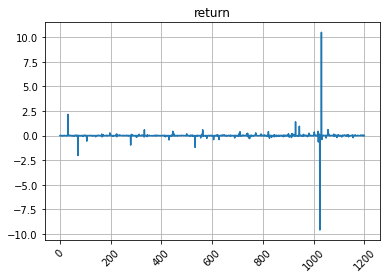

In [91]:
get_portfolio_stats(1, 1, 'equities')

In get_portfolio_data()
In return_pval_df()
Mean    : 0.015
Std     : 0.572
Sharpe  : 0.4163


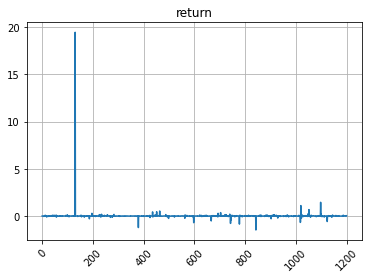

In [92]:
get_portfolio_stats(1, 2, 'equities')

In get_portfolio_data()
In return_pval_df()
Mean    : -0.007
Std     : 0.1951
Sharpe  : -0.5696


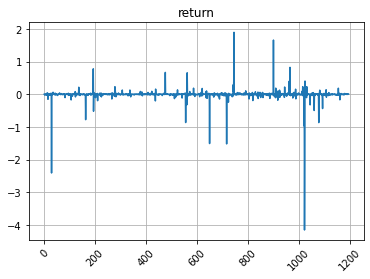

In [93]:
get_portfolio_stats(1, 3, 'equities')

In get_portfolio_data()
In return_pval_df()
Mean    : -0.0042
Std     : 0.2371
Sharpe  : -0.2812


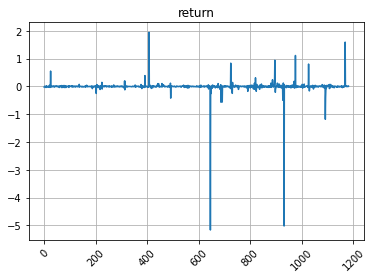

In [94]:
get_portfolio_stats(1, 4, 'equities')

In get_portfolio_data()
In return_pval_df()
Mean    : 0.0051
Std     : 0.5052
Sharpe  : 0.1603


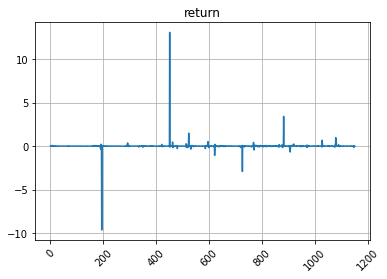

In [95]:
get_portfolio_stats(1, 5, 'equities')

In get_portfolio_data()
In return_pval_df()
Mean    : -0.004
Std     : 0.5542
Sharpe  : -0.1146


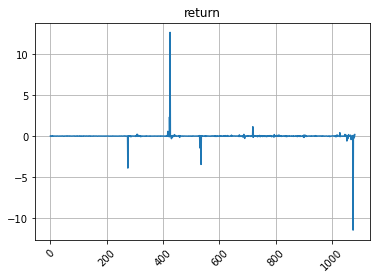

In [96]:
get_portfolio_stats(1, 6, 'equities')

In get_portfolio_data()
In return_pval_df()
Mean    : 0.0059
Std     : 0.1693
Sharpe  : 0.5532


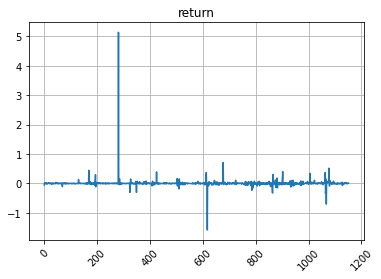

In [97]:
get_portfolio_stats(1, 7, 'equities')

In get_portfolio_data()
In return_pval_df()
Mean    : 0.0046
Std     : 0.1017
Sharpe  : 0.718


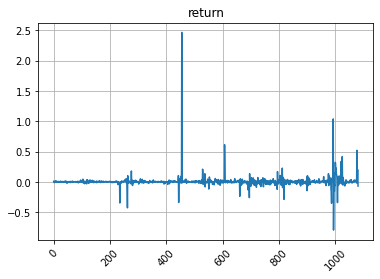

In [98]:
get_portfolio_stats(1, 8, 'equities')

In get_portfolio_data()
In return_pval_df()
Mean    : 0.0144
Std     : 0.5388
Sharpe  : 0.4243


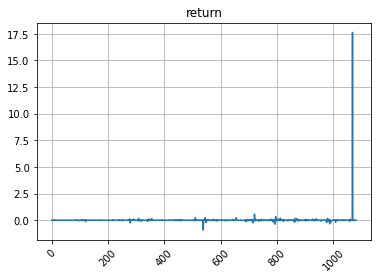

In [99]:
get_portfolio_stats(1, 9, 'equities')

In get_portfolio_data()
In return_pval_df()
Mean    : 0.0017
Std     : 0.0774
Sharpe  : 0.3487


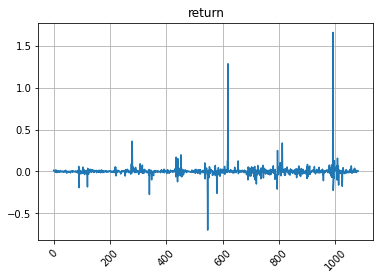

In [100]:
get_portfolio_stats(1, 10, 'equities')

### Index based rules

In get_portfolio_data()
In return_pval_df()
Mean    : 0.0059
Std     : 0.2376
Sharpe  : 0.3942


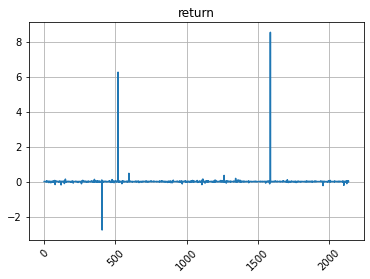

In [101]:
get_portfolio_stats(1, 1, 'index')

In get_portfolio_data()
In return_pval_df()
Mean    : -0.0015
Std     : 0.2803
Sharpe  : -0.085


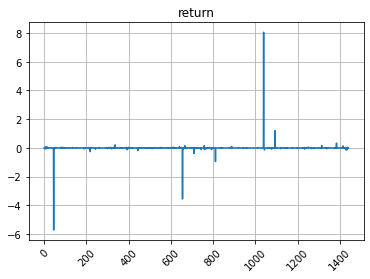

In [102]:
get_portfolio_stats(1, 2, 'index')

In get_portfolio_data()
In return_pval_df()
Mean    : 0.0005
Std     : 0.039
Sharpe  : 0.2035


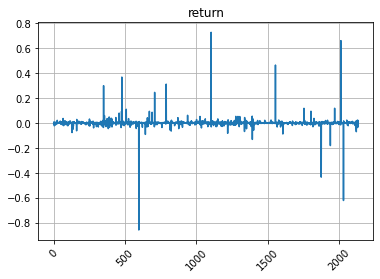

In [103]:
get_portfolio_stats(1, 3, 'index')

In get_portfolio_data()
In return_pval_df()
Mean    : -0.003
Std     : 0.084
Sharpe  : -0.5669


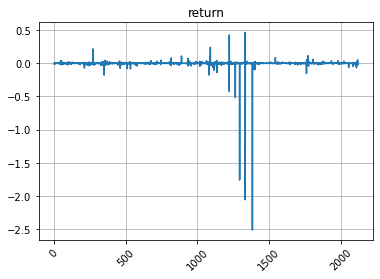

In [105]:
get_portfolio_stats(1, 4, 'index')

In get_portfolio_data()
In return_pval_df()
Mean    : 0.0009
Std     : 0.0249
Sharpe  : 0.5738


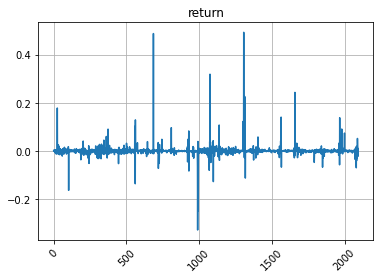

In [106]:
get_portfolio_stats(1, 5, 'index')

In get_portfolio_data()
In return_pval_df()
Mean    : -0.0007
Std     : 0.0194
Sharpe  : -0.5728


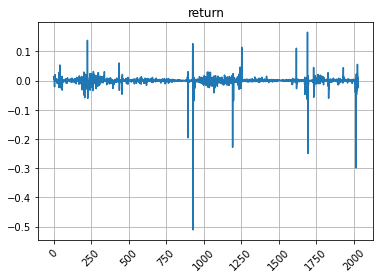

In [107]:
get_portfolio_stats(1, 6, 'index')

In get_portfolio_data()
In return_pval_df()
Mean    : -0.0019
Std     : 0.0613
Sharpe  : -0.492


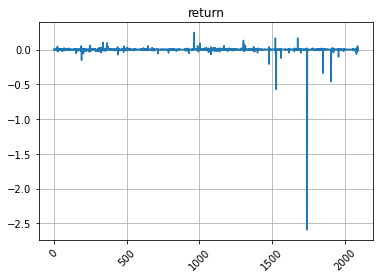

In [108]:
get_portfolio_stats(1, 7, 'index')

In get_portfolio_data()
In return_pval_df()
Mean    : 0.0
Std     : 0.1038
Sharpe  : 0.0


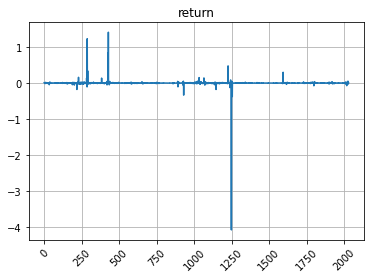

In [109]:
get_portfolio_stats(1, 8, 'index')

In get_portfolio_data()
In return_pval_df()
Mean    : 0.0332
Std     : 1.5265
Sharpe  : 0.3453


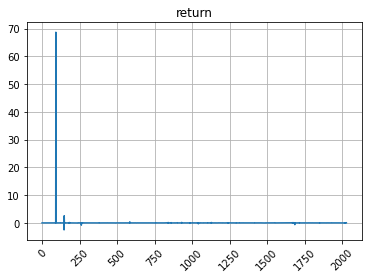

In [110]:
get_portfolio_stats(1, 9, 'index')

In get_portfolio_data()
In return_pval_df()
Mean    : 0.0015
Std     : 0.0291
Sharpe  : 0.8183


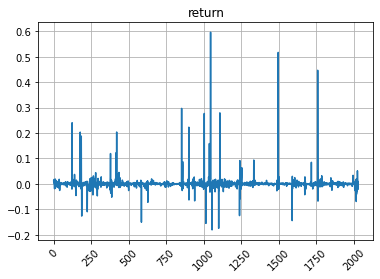

In [111]:
get_portfolio_stats(1, 10, 'index')